# Assignment 4

## AI usage

I have used DeepSeek as my AI support. I have admittedly used a lot of AI for this assignment, as I haven't had much extra time. Key points I have used AI for on this assignment: 

- understanding code for maps
- producing some code for maps 
- translating code chunks between libraries (f.ex. `matplotlib` -> `plotly`)

When using AI, I have tried to make sure that I build the code in steps, so that I understand the code and the changes that AI implements. 

## Log

Working on this assignment I am working first on requirements for the Jupyter Notebook and subsequently updating the Streamlit app. 

I really enjoyed working with the same import structure as in Assignment 2, with the Elhub API. However, I realized that the name I chose for the tables (`elhub_api`) in Cassandra and MongoDB weren't descriptive enough, as we now are using two tables from the same API. I was also unsure of whether the new production data from 2022-2024 should be strictly appended to the old tables or if I could remake the tables with data 2021-2024. I found that the easiest would be to start the databases from scratch (also with regards to reproducibility and control), so that's what I did. Manipulating data with Spark and inserting into Cassandra and MongoDB was otherwise fine, mostly following the same structure from Assignment 2.

Updates for the Streamlit app have felt difficult as I haven't caught up with the progress in the lectures. 

I spent a lot of time working on the map requirement. I have looked into a lot of documentation, but as this is very time consuming I felt like I had to get help from AI. I started by implementing a map with `plotly` and managed to get the price area outlines right. However, I found no resources on how to interact with the map and marking a clicked location with this library. I found a discussion on this matter using `folium`, and so I tried using this to see if the implementation was easier. Working on the map implementations, I tried different approaches in separate scripts in the `streamlit_lectures`-folder so that I could monitor the progress immidiately. 

Honestly, I have spent about three days worth of time figuring out the map. At this point I am unsure of how much time we are estimated to spend on each of these tasks and if I am just ridiculously behind. 

## Links 

- Github: https://github.com/Satheris/IND320_SMAA
- Streamlit app: https://ind320smaa-2eg32uba6uhmrknkwtxzar.streamlit.app/

## Coding 

### Imports and system variables

In [55]:
import numpy as np
import pandas as pd 
import streamlit as st
import pymongo
from cassandra.cluster import Cluster
from pyspark.sql import SparkSession
from pyjstat import pyjstat
import requests
import json
import plotly.express as px
from pyspark import SparkConf, SparkContext
import requests_cache

import plotly.io as pio
pio.renderers.default = "notebook+pdf+plotly_mimetype"

%matplotlib inline

In [56]:
# Set environment variables for PySpark (system and version dependent!) 
# if not already set persistently (e.g., in .bashrc or .bash_profile or Windows environment variables)
import os
# Set the Java home path to the one you are using ((un)comment and edit as needed):
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jre1.8.0_471"

# If you are using environments in Python, you can set the environment variables like the alternative below.
# The default Python environment is used if the variables are set to "python" (edit if needed):
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"

# On Windows you need to specify where the Hadoop drivers are located (uncomment and edit if needed):
os.environ["HADOOP_HOME"] = r"C:\Users\saraa\Documents\winutils\hadoop-3.3.1"

# Set the Hadoop version to the one you are using, e.g., none:
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

### Cassandra and Spark

In [59]:
# Connecting to Cassandra
# Run local Docker container first
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

WARNING	cassandra.cluster:cluster.py:__init__()- Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['localhost'], lbp = None)
WARNING	cassandra.cluster:cluster.py:protocol_downgrade()- Downgrading core protocol version from 66 to 65 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
WARNING	cassandra.cluster:cluster.py:protocol_downgrade()- Downgrading core protocol version from 65 to 5 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version


In [60]:
# Set up new keyspace
#                                              name of keyspace                        replication strategy           replication factor
session.execute("CREATE KEYSPACE IF NOT EXISTS ind320_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

# assign keyspace
session.set_keyspace('ind320_keyspace')

# drop tables to start from scratch every time 
# session.execute("DROP TABLE IF EXISTS ind320_keyspace.elhub_api;")    # table used in Assignment 2
session.execute("DROP TABLE IF EXISTS ind320_keyspace.elhub_production;")
session.execute("DROP TABLE IF EXISTS ind320_keyspace.elhub_consumption;")

# Create new tables 
session.execute("CREATE TABLE IF NOT EXISTS elhub_production \
                (ind int PRIMARY KEY, startTime text, endTime text, lastUpdatedTime text, \
                productionGroup text, quantityKwh float, \
                priceArea text);")
session.execute("CREATE TABLE IF NOT EXISTS elhub_consumption \
                (ind int PRIMARY KEY, startTime text, endTime text, lastUpdatedTime text, \
                consumptionGroup text, quantityKwh float, \
                priceArea text, meteringPointCount int)")

In [61]:
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.5.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').\
    config('spark.driver.host', 'localhost').\
    config('spark.driver.bindAddress', '127.0.0.1').\
    config('spark.sql.adaptive.enabled', 'true').\
        getOrCreate()

#### Testing that the connection works

In [62]:
# .load() is used to load data from Cassandra table as a Spark DataFrame
spark.read.format("org.apache.spark.sql.cassandra").options(table="my_first_table", keyspace="my_first_keyspace").load().show()

+---+--------+-------+
|ind| company|  model|
+---+--------+-------+
|460|    Ford|Transit|
|459|    Ford| Escort|
|  1|   Tesla|Model S|
|  2|   Tesla|Model 3|
|  3|Polestar|      3|
+---+--------+-------+



### MongoDB

In [71]:
def init_connection():
    return pymongo.MongoClient(st.secrets["mongo"]["uri"])

client = init_connection()

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


### Elhub API

#### Production data

In [72]:
# initating lists for traversing the URL
years = [2021, 2022, 2023, 2024, 2025]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


all_records = []

for i, year in enumerate(years[:-1]):
    for j, month in enumerate(months):

        # catching last month with adapted URL for end time
        if month == months[-1]:
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=PRODUCTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={years[i+1]}-{months[0]}-01T00:00:00%2B02:00'
            
        # all other months follow the same structure
        else: 
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=PRODUCTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={year}-{months[j+1]}-01T00:00:00%2B02:00'

        payload = { 
            "query": [], 
            "response": { "format": "json-stat2" } }

        response = requests.get(URL, json=payload)
        
        # print(f"Y:{year}, m:{month}, Status Code: {response.status_code}")

        data = response.json()

        for area in data['data']:
            records = area['attributes']['productionPerGroupMbaHour']
            for record in records:
                record['priceArea'] = area['attributes']['name']
                all_records.append(record)

elhub_production = pd.DataFrame(all_records)
elhub_production.index.name = 'ind'
elhub_production = elhub_production.reset_index()

print(f"\nCreated DataFrame with {len(elhub_production)} rows")
print(elhub_production.head())


Created DataFrame with 872953 rows
   ind                    endTime            lastUpdatedTime priceArea  \
0    0  2021-01-01T01:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
1    1  2021-01-01T02:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
2    2  2021-01-01T03:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
3    3  2021-01-01T04:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
4    4  2021-01-01T05:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   

  productionGroup  quantityKwh                  startTime  
0           hydro    2507716.8  2021-01-01T00:00:00+01:00  
1           hydro    2494728.0  2021-01-01T01:00:00+01:00  
2           hydro    2486777.5  2021-01-01T02:00:00+01:00  
3           hydro    2461176.0  2021-01-01T03:00:00+01:00  
4           hydro    2466969.2  2021-01-01T04:00:00+01:00  


In [73]:
print(elhub_production.head())
elhub_production.groupby(['priceArea', 'productionGroup'])['quantityKwh'].sum().reset_index()

   ind                    endTime            lastUpdatedTime priceArea  \
0    0  2021-01-01T01:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
1    1  2021-01-01T02:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
2    2  2021-01-01T03:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
3    3  2021-01-01T04:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
4    4  2021-01-01T05:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   

  productionGroup  quantityKwh                  startTime  
0           hydro    2507716.8  2021-01-01T00:00:00+01:00  
1           hydro    2494728.0  2021-01-01T01:00:00+01:00  
2           hydro    2486777.5  2021-01-01T02:00:00+01:00  
3           hydro    2461176.0  2021-01-01T03:00:00+01:00  
4           hydro    2466969.2  2021-01-01T04:00:00+01:00  


,priceArea,productionGroup,quantityKwh
0,NO1,hydro,7.331962e+10
1,NO1,other,1.807132e+06
2,NO1,solar,2.386185e+08
3,NO1,thermal,9.895175e+08
4,NO1,wind,3.198696e+09
5,NO2,hydro,1.872465e+11
6,NO2,other,4.392108e+06
7,NO2,solar,2.029792e+08
8,NO2,thermal,6.786122e+08
9,NO2,wind,1.678158e+10


#### Consumption data

In [74]:
# initating lists for traversing the URL
years = [2021, 2022, 2023, 2024, 2025]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


all_records = []

for i, year in enumerate(years[:-1]):
    for j, month in enumerate(months):
        
        # catching last month with adapted URL for end time
        if month == months[-1]:
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=CONSUMPTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={years[i+1]}-{months[0]}-01T00:00:00%2B02:00'
        
        # all other months follow the same structure
        else: 
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=CONSUMPTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={year}-{months[j+1]}-01T00:00:00%2B02:00'

        payload = { 
            "query": [], 
            "response": { "format": "json-stat2" } }

        response = requests.get(URL, json=payload)
        
        # print(f"Y:{year}, m:{month}, Status Code: {response.status_code}")

        data = response.json()

        for area in data['data']:
            records = area['attributes']['consumptionPerGroupMbaHour']
            for record in records:
                record['priceArea'] = area['attributes']['name']
                all_records.append(record)

elhub_consumption = pd.DataFrame(all_records)
elhub_consumption.index.name = 'ind'
elhub_consumption = elhub_consumption.reset_index()

print(f"\nCreated DataFrame with {len(elhub_consumption)} rows")
elhub_consumption.head()


Created DataFrame with 876600 rows


,ind,consumptionGroup,endTime,lastUpdatedTime,meteringPointCount,priceArea,quantityKwh,startTime
0,0,cabin,2021-01-01T01:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,177071.56,2021-01-01T00:00:00+01:00
1,1,cabin,2021-01-01T02:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,171335.12,2021-01-01T01:00:00+01:00
2,2,cabin,2021-01-01T03:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,164912.02,2021-01-01T02:00:00+01:00
3,3,cabin,2021-01-01T04:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,160265.77,2021-01-01T03:00:00+01:00
4,4,cabin,2021-01-01T05:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,159828.69,2021-01-01T04:00:00+01:00


In [75]:
# I found that the columns in the Cassandra table was constructed with lowercase letters.
# Therefore, I need to convert the column names to lowercase before writing to Cassandra

str_list = ['elhub_production', 'elhub_consumption']

for i, table in enumerate([elhub_production, elhub_consumption]):
    name_dict = {}
    for capitalname in (table.columns):
        name_dict[capitalname] = capitalname.lower()
    
    table = table.rename(columns=name_dict)

    # Convert the Pandas DataFrame to Spark DataFrame and save it to Cassandra (append mode)
    spark.createDataFrame(table).write.format('org.apache.spark.sql.cassandra')\
    .options(table=str_list[i], keyspace='ind320_keyspace').mode('append').save()

    print(f'Saved {str_list[i]} to Cassandra')

Saved elhub_production to Cassandra
Saved elhub_consumption to Cassandra


### Saving dfs to MongoDB

In [76]:
# Selecting a database and a collection
database = client['project']

for table in str_list:
    collection = database[table]
    collection.delete_many({}) # starting fresh

    spark.read.format("org.apache.spark.sql.cassandra")\
    .options(table=table, keyspace="ind320_keyspace").load()\
    .createOrReplaceTempView(f"{table}_view")

    df_spark = spark.sql(f"SELECT priceArea, {table.split('_')[1]}Group, startTime, quantityKwh FROM {table}_view")

    # Convert DataFrame to JSON and dumping to MongoDB
    df_pd = df_spark.toPandas()
    json_data = df_pd.to_json(orient='records')

    documents = json.loads(json_data)
    try: 
        collection.insert_many(documents)
        print(f'Successfully inserted {table} to MongoDB')
    except Exception as e:
        print(e)

Successfully inserted elhub_production to MongoDB
Successfully inserted elhub_consumption to MongoDB


### Stopping Spark session

In [77]:
# Stop Spark session
try:
    spark.stop()
    print('Spark session terminated successfully')
except ConnectionRefusedError:
    print("Spark session already stopped.")
except NameError:
    print('Spark session is not defined')

Spark session terminated successfully


### Testing for Streamlit app

#### Plotly map

In [30]:
import pandas as pd
import plotly.graph_objects as go
import json
import plotly.express as px

# Add this to see what properties are available
with open(r'C:\Users\saraa\Documents\IND320_SMAA\project\data\file.geojson') as file:
    priceAreas = json.load(file)

for thing in priceAreas['features']:
    print(thing['properties']['ElSpotOmr'])
    splitted = thing['properties']['ElSpotOmr'].split(' ')
    combined = splitted[0]+splitted[1]
    print(combined)

# # Print the first feature to see the structure
# print("First feature structure:")
# print(json.dumps(priceAreas['features'][0], indent=2))

NO 2
NO2
NO 5
NO5
NO 1
NO1
NO 3
NO3
NO 4
NO4


In [34]:
groups = ['hydro', 'other', 'solar', 'thermal', 'wind']
groups.sort()

group = 'other'

groups.index(group)

1

In [9]:
# # def calculate_centroid(geometry):
# #     """Calculate the centroid of a GeoJSON geometry"""
# #     if geometry['type'] == 'Polygon':
# #         coordinates = geometry['coordinates'][0]  # exterior ring
# #     elif geometry['type'] == 'MultiPolygon':
# #         # Use the largest polygon for centroid calculation
# #         polygons = geometry['coordinates']
# #         largest_polygon = max(polygons, key=lambda poly: len(poly[0]))
# #         coordinates = largest_polygon[0]
# #     else:
# #         return None
    
# #     # Calculate centroid using mean of coordinates
# #     lons = [coord[0] for coord in coordinates]
# #     lats = [coord[1] for coord in coordinates]
    
# #     centroid_lon = sum(lons) / len(lons)
# #     centroid_lat = sum(lats) / len(lats)
    
# #     return [centroid_lon, centroid_lat]


# # Create a dummy dataframe with area identifiers
# # Replace 'area_id' with the actual property name from your GeoJSON
# area_ids = [feature['properties']['OBJECTID'] for feature in priceAreas['features']]
# area_names = [feature['properties']['ElSpotOmr'] for feature in priceAreas['features']]
# df = pd.DataFrame({'area_id': area_ids, 
#                    'dummy_value': [1]*len(area_ids),
#                    'area_names': area_names})


# # Create the map
# fig = px.choropleth_map(
#     df,
#     geojson=priceAreas,
#     locations='area_id',
#     featureidkey="properties.OBJECTID",
#     color='dummy_value',
#     color_continuous_scale=[(0, "rgba(0,0,0,0)"), (1, "rgba(0,0,0,0)")],  # Transparent colors
#     map_style="open-street-map",
#     zoom=3,
#     center={"lat": 65, "lon": 8},
#     labels={'dummy_value': ''},
# )

# # Customize outlines
# fig.update_traces(
#     marker_line_width=2,
#     marker_line_color="#e8862a",
#     showscale=False
# )

# # # Calculate centroids and add text annotations
# # for feature in priceAreas['features']:
# #     # Get the area name from properties (adjust property name as needed)
# #     area_name = feature['properties'].get('name', f"Area {feature['properties']['OBJECTID']}")
    
# #     # Calculate centroid of the polygon
# #     centroid = calculate_centroid(feature['geometry'])
    
# #     if centroid:
# #         Add text annotation at centroid
# #     fig.add_annotation(
# #         x=centroid[0],  # longitude
# #         y=centroid[1],  # latitude
# #         text=area_name,
# #         showarrow=False,
# #         font=dict(size=10, color="black"),
# #         bgcolor="white",
# #         bordercolor="black",
# #         borderwidth=1,
# #         borderpad=2,
# #         opacity=1
# #     )

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [10]:
# def map_outline(df=None):
#     with open(r'C:\Users\saraa\Documents\IND320_SMAA\project\data\file.geojson') as file:
#         priceAreas = json.load(file)

#     if df is None:
#         area_ids = [feature['properties']['OBJECTID'] for feature in priceAreas['features']]
#         area_names = [feature['properties']['ElSpotOmr'] for feature in priceAreas['features']]
#         df = pd.DataFrame({'area_id': area_ids, 
#                         'dummy_value': [1]*len(area_ids),
#                         'area_names': area_names})

#     fig = go.Figure()

#     fig.add_trace(go.Choroplethmap(
#         geojson=priceAreas,
#         locations=df['area_id'],
#         featureidkey="properties.OBJECTID",
#         z=df['dummy_value'],
#         colorscale=[(0, "rgba(0,0,0,0)"), (1, "rgba(0,0,0,0)")],
#         showscale=False,
#         marker_line_width=2,
#         marker_line_color="#e8862a",
#         marker_opacity=0,  # Transparent by default
#         # Custom selection styling
#         selectedpoints=None,  # Initialize with no selection
#         selected=dict(
#             marker=dict(opacity=0.7, color="#2ca02c")  # Only color and opacity
#         ),
#         unselected=dict(
#             marker=dict(opacity=0)  # Only opacity
#         )
#     ))

#     fig.update_layout(
#         mapbox_style="open-street-map",
#         mapbox_zoom=4,
#         mapbox_center={"lat": 64.0, "lon": 12.0},
#         margin={"r":0,"t":0,"l":0,"b":0},
#         height=600,
#         width=400
#     )

#     return fig
# map_outline()

In [11]:
# def map_outline(df=None):
#     with open(r'C:\Users\saraa\Documents\IND320_SMAA\project\data\file.geojson') as file:
#         priceAreas = json.load(file)

#     if df is None:
#         area_ids = [feature['properties']['OBJECTID'] for feature in priceAreas['features']]
#         area_names = [feature['properties']['ElSpotOmr'] for feature in priceAreas['features']]
#         df = pd.DataFrame({'area_id': area_ids, 
#                         'dummy_value': [1]*len(area_ids),
#                         'area_names': area_names})

#     # Create the map
#     fig = px.choropleth_map(
#         df,
#         geojson=priceAreas,
#         locations='area_id',
#         featureidkey="properties.OBJECTID",
#         color='dummy_value',
#         color_continuous_scale=[(0, "rgba(0,0,0,0)"), (1, "rgba(0,0,0,0)")],
#         map_style="open-street-map",
#         zoom=4,
#         center={"lat": 64.0, "lon": 12.0},
#         labels={'dummy_value': ''},
#     )

#     # Customize selection behavior - simplified
#     fig.update_traces(
#         marker_line_width=2,
#         marker_line_color="#e8862a",
#         selected=dict(marker=dict(color="#2ca02c", opacity=0.7)),
#         unselected=dict(marker=dict(opacity=0))
#     )
    
#     fig.update_layout(
#         margin={"r":0,"t":0,"l":0,"b":0},
#         height=600,
#         width=400,
#         coloraxis_showscale=False
#     )

#     return fig
# map_outline()

In [12]:
# def map_outline(df=None):
#     with open(r'C:\Users\saraa\Documents\IND320_SMAA\project\data\file.geojson') as file:
#         priceAreas = json.load(file)

#     if df is None:
#         area_ids = [feature['properties']['OBJECTID'] for feature in priceAreas['features']]
#         area_names = [feature['properties']['ElSpotOmr'] for feature in priceAreas['features']]
#         df = pd.DataFrame({'area_id': area_ids, 
#                         'dummy_value': [1]*len(area_ids),
#                         'area_names': area_names})

#     fig = go.Figure()

#     fig.add_trace(go.Choroplethmapbox(
#         geojson=priceAreas,
#         locations=df['area_id'],
#         featureidkey="properties.OBJECTID",
#         z=df['dummy_value'],
#         colorscale=[(0, "rgba(0,0,0,0)"), (1, "rgba(0,0,0,0)")],
#         showscale=False,
#         marker_line_width=2,
#         marker_line_color="#e8862a",
#         marker_opacity=0,
#         hoverinfo="text",
#         hovertext=df['area_names'],  # Show area name on hover
#         # Enhanced hover effects
#         hoverlabel=dict(bgcolor="white", font_size=12),
#         hovertemplate="<b>%{hovertext}</b><extra></extra>"
#     ))

#     fig.update_layout(
#         mapbox_style="open-street-map",
#         mapbox_zoom=4,
#         mapbox_center={"lat": 64.0, "lon": 12.0},
#         margin={"r":0,"t":0,"l":0,"b":0},
#         height=600,
#         width=400,
#         # Disable the default selection behavior if it's problematic
#         clickmode='event+select'
#     )

#     return fig
# map_outline()

In [ ]:
import folium
# Load and add GeoJSON regions
try:
    # Load the GeoJSON file
    with open(r'project/data/file.geojson', 'r', encoding='utf-8') as f:
        geojson_data = json.load(f)
    
    # Create the base map
    m = folium.Map(location=st.session_state.map_center, zoom_start=st.session_state.zoom)
    
    # Add base GeoJSON layer with default styling (no highlighting)
    base_geojson = folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': 'lightblue',
            'color': '#e8862a',
            'weight': 2,
            'fillOpacity': 0,
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['ElSpotOmr'],
            aliases=['Region:'],
            localize=True
        ),
        name="Base Regions"  # Give it a name for layer control
    ).add_to(m)
    
    # Add a separate overlay layer for the highlighted region
    # if st.session_state.selected_region_feature is not None:
        # highlight_geojson = folium.GeoJson(
        #     st.session_state.selected_region_feature,
        #     style_function=lambda feature: {
        #         'fillColor': 'orange',
        #         'color': "#e82a2a", #rgba(0,0,0,0)
        #         'weight': 3,  # Thicker border for emphasis
        #         'fillOpacity': 0, 
        #         'dashArray': '0'  # Ensure no dashes
        #     },
        #     name="Selected Region"
        # ).add_to(m)
    
    # Add CSS to remove the black box highlight
    m.get_root().header.add_child(folium.Element("""
    <style>
    /* Remove the black box highlight on click */
    .leaflet-interactive.leaflet-touch-drag {
        stroke-dasharray: none !important;
        stroke-dashoffset: 0 !important;
    }
    
    /* Remove focus outline without affecting stroke color */
    .leaflet-interactive:focus {
        outline: none !important;
    }
    </style>
    """))
    
    # Store the GeoJSON data in session state for region detection
    # st.session_state.geojson_data = geojson_data
    
except FileNotFoundError:
    st.error("GeoJSON file not found. Please make sure 'file.geojson' exists in the same directory.")
    # Create map without GeoJSON if file not found
    m = folium.Map(location=st.session_state.map_center, zoom_start=st.session_state.zoom)
except Exception as e:
    st.error(f"Error loading GeoJSON file: {e}")
    m = folium.Map(location=st.session_state.map_center, zoom_start=st.session_state.zoom)


# # Add marker only if a location has been clicked
# if st.session_state.marker_location is not None:
#     # Use CircleMarker for precise positioning
#     folium.CircleMarker(
#         location=st.session_state.marker_location,
#         radius=8,
#         popup=f"Coordinates: {st.session_state.marker_location}",
#         color="red",
#         fillColor="red",
#         fillOpacity=0.7,
#         weight=2
#     ).add_to(m)

# if st.session_state['energy_type']:
folium.Choropleth(
    geo_data=elhub_production[],
    data=state_data,
    columns=["State", "Unemployment"],
    key_on="feature.id",
).add_to(m)

m

In [ ]:
elhub_production.groupby(by='priceArea')

#### Snow drift 

In [16]:
from utils.snowdrift import snowdrift_plot
from utils.common import area_to_geoplacement
import openmeteo_requests
import requests_cache
from retry_requests import retry

# from utils/common.py
# modified to download July-June time period
def openmeteo_download_snowdrift(area, startYear=2021, endYear=2022) -> pd.DataFrame:
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    longitude, latitude = area_to_geoplacement(area)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{startYear}-07-01",
        "end_date": f"{endYear}-06-30",
        "hourly": ["temperature_2m", "wind_direction_10m", "wind_speed_10m", "wind_gusts_10m", "precipitation"],
        "models": "era5",
        "timezone": "Europe/Berlin",
        "wind_speed_unit": "ms"}
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]    

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"time": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True), # .tz_convert('Europe/Oslo'),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True), # .tz_convert('Europe/Oslo'),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left")}
    
    hourly_data['time'] = pd.to_datetime(hourly_data['time']).tz_localize(None) + pd.Timedelta(hours=1)

    hourly_data["temperature_2m (°C)"] = hourly_temperature_2m
    hourly_data["wind_direction_10m (°)"] = hourly_wind_direction_10m
    hourly_data["wind_speed_10m (m/s)"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m (m/s)"] = hourly_wind_gusts_10m
    hourly_data["precipitation (mm)"] = hourly_precipitation

    df = pd.DataFrame(data = hourly_data)

    return df

# openmeteo_download_snowdrift('NO1')

snowdrift_plot(openmeteo_download_snowdrift('NO1', endYear=2024))


Yearly average snow drift (Qt) per season:
   season Qt (kg/m)
2021-2022   14119.1
2022-2023   13359.1
2023-2024   16052.3

Yearly average snow drift (Qt) per season (in tonnes/m) and control type:
   season Qt (tonnes/m)         Control
2021-2022          14.1 Wind controlled
2022-2023          13.4 Wind controlled
2023-2024          16.1 Wind controlled

Overall average Qt over all seasons: 14.5 tonnes/m

Necessary fence heights per season (in meters):
   season Wyoming (m) Slat-and-wire (m) Solid (m)
2021-2022         1.3               1.3       2.1
2022-2023         1.2               1.3       2.0
2023-2024         1.3               1.4       2.2


In [17]:
def sector_index(direction):
    """
    Given a wind direction in degrees, returns the index (0-15)
    corresponding to a 16-sector division.
    """
    # Center the bin by adding 11.25° then modulo 360 and divide by 22.5°
    return int(((direction + 11.25) % 360) // 22.5)

def compute_sector_transport(hourly_wind_speeds, hourly_wind_dirs, dt=3600):
    """
    Compute the cumulative transport for each of 16 wind sectors.
    
    Parameters:
      hourly_wind_speeds: list of wind speeds [m/s]
      hourly_wind_dirs: list of wind directions [degrees]
      dt: time step in seconds
      
    Returns:
      A list of 16 transport values (kg/m) corresponding to the sectors.
    """
    sectors = [0.0] * 16
    for u, d in zip(hourly_wind_speeds, hourly_wind_dirs):
        idx = sector_index(d)
        sectors[idx] += ((u ** 3.8) * dt) / 233847
    return sectors

def compute_average_sector(df):
    """
    Compute the average directional breakdown (sectors) over all seasons.
    The function groups the data by season and computes the sector contributions
    for each season, then returns the mean across seasons.
    """
    sectors_list = []
    for s, group in df.groupby('season'):
        group = group.copy()
        group['Swe_hourly'] = group.apply(
            lambda row: row['precipitation (mm)'] if row['temperature_2m (°C)'] < 1 else 0, axis=1)
        ws = group["wind_speed_10m (m/s)"].tolist()
        wdir = group["wind_direction_10m (°)"].tolist()
        sectors = compute_sector_transport(ws, wdir)
        sectors_list.append(sectors)
    avg_sectors = np.mean(sectors_list, axis=0)

    return avg_sectors

# compute_sector_transport(range(0, 16), range(0, 360, 23))

df_snow = openmeteo_download_snowdrift('NO1', endYear=2024)
# Convert the 'time' column to datetime.
df_snow['time'] = pd.to_datetime(df_snow['time'])

# Define season: if month >= 7, season = current year; otherwise, season = previous year.
df_snow['season'] = df_snow['time'].apply(lambda dt: dt.year if dt.month >= 7 else dt.year - 1)

compute_average_sector(df_snow)

array([1309.60334517, 1331.18004418,  972.06032873,  453.46951928,
        298.47331408,  441.37498997,  340.59756169,  947.98865877,
       2563.94760168, 2993.28766714,  529.35376433,  257.40687545,
        322.00158569,  464.64525821,  547.4843797 ,  737.26160423])

#### Meteorology

In [36]:
elhub_production.groupby('startTime').sum().reset_index()

,startTime,ind,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh
0,2021-01-01T00:00:00+01:00,205344,2021-01-01T01:00:00+01:002021-01-01T01:00:00+0...,2024-12-20T10:35:40+01:002024-12-20T10:35:40+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,2.121690e+07
1,2021-01-01T01:00:00+01:00,205368,2021-01-01T02:00:00+01:002021-01-01T02:00:00+0...,2024-12-20T10:35:40+01:002024-12-20T10:35:40+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,2.070951e+07
2,2021-01-01T02:00:00+01:00,205392,2021-01-01T03:00:00+01:002021-01-01T03:00:00+0...,2024-12-20T10:35:40+01:002024-12-20T10:35:40+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,1.985081e+07
3,2021-01-01T03:00:00+01:00,205416,2021-01-01T04:00:00+01:002021-01-01T04:00:00+0...,2024-12-20T10:35:40+01:002024-12-20T10:35:40+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,1.944924e+07
4,2021-01-01T04:00:00+01:00,205440,2021-01-01T05:00:00+01:002021-01-01T05:00:00+0...,2024-12-20T10:35:40+01:002024-12-20T10:35:40+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,1.948099e+07
...,...,...,...,...,...,...,...
35059,2024-12-31T19:00:00+01:00,21600500,2024-12-31T20:00:00+01:002024-12-31T20:00:00+0...,2025-03-30T18:39:27+02:002025-03-30T18:39:27+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,2.127404e+07
35060,2024-12-31T20:00:00+01:00,21600525,2024-12-31T21:00:00+01:002024-12-31T21:00:00+0...,2025-03-30T18:39:27+02:002025-03-30T18:39:27+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,1.963888e+07
35061,2024-12-31T21:00:00+01:00,21600550,2024-12-31T22:00:00+01:002024-12-31T22:00:00+0...,2025-03-30T18:39:27+02:002025-03-30T18:39:27+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,1.751152e+07
35062,2024-12-31T22:00:00+01:00,21600575,2024-12-31T23:00:00+01:002024-12-31T23:00:00+0...,2025-03-30T18:39:27+02:002025-03-30T18:39:27+0...,NO1NO1NO1NO1NO1NO2NO2NO2NO2NO2NO3NO3NO3NO3NO3N...,hydroothersolarthermalwindhydroothersolartherm...,1.586365e+07


In [46]:
def openmeteo_download(area, year=2021) -> pd.DataFrame:
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    longitude, latitude = area_to_geoplacement(area)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": ["temperature_2m", "wind_direction_10m", "wind_speed_10m", "wind_gusts_10m", "precipitation"],
        "models": "era5",
        "timezone": "Europe/Berlin",
        "wind_speed_unit": "ms"}
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]    

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"time": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True).tz_convert('Europe/Oslo'),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True).tz_convert('Europe/Oslo'),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left")}

    hourly_data["temperature_2m (°C)"] = hourly_temperature_2m
    hourly_data["wind_direction_10m (°)"] = hourly_wind_direction_10m
    hourly_data["wind_speed_10m (m/s)"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m (m/s)"] = hourly_wind_gusts_10m
    hourly_data["precipitation (mm)"] = hourly_precipitation

    df = pd.DataFrame(data = hourly_data)

    return df

def area_to_geoplacement(area):
    geo_dict = {'NO1': {'long': 10.7461, 'lat': 59.9127},
                'NO2': {'long': 7.9956, 'lat': 58.1467},
                'NO3': {'long': 5.3242, 'lat': 60.393},
                'NO4': {'long': 18.9551, 'lat': 69.6489},
                'NO5': {'long': 10.3951, 'lat': 63.4305}}
    
    return geo_dict[area]['long'], geo_dict[area]['lat']



In [47]:
from retry_requests import retry
import openmeteo_requests

# # Convert time to datetime if it's not already
# agg_weather = pd.DataFrame(st.session_state['weather_data'])
# agg_weather['time'] = pd.to_datetime(agg_weather['time'])

# # Aggregate to daily data 
# daily_weather = agg_weather.groupby(pd.Grouper(key='time', freq='D')).agg({weather_variable:'sum'}).reset_index()
# weather_series = daily_weather[weather_variable]

agg_weather = openmeteo_download('NO1')
agg_weather['time'] = pd.to_datetime(agg_weather['time'])

daily_weather = agg_weather.groupby(pd.Grouper(key='time', freq='D')).agg({'precipitation (mm)':'sum'}).reset_index()
weather_series = daily_weather['precipitation (mm)']

weather_series

0      2.4
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
360    0.0
361    7.2
362    0.1
363    6.6
364    0.0
Name: precipitation (mm), Length: 365, dtype: float32

#### Forecasting energy data 

In [49]:
# def make_sarimax_subset() -> pd.DataFrame:
#     # df = st.session_state[st.session_state['ENERGY_TYPE']+'_data']
#     df = elhub_production.copy()
    
#     df['startTime'] = pd.to_datetime(df['startTime'])

#     # df_daily = df.groupby([st.session_state['ENERGY_TYPE']+'Group', pd.Grouper(key='startTime', freq='D')]).agg({'quantityKwh': 'sum'}).reset_index()
#     df_daily = df.groupby(['productionGroup', pd.Grouper(key='startTime', freq='D')]).agg({'quantityKwh': 'sum'}).reset_index()

#     df_daily.index = df_daily['startTime']

#     return df_daily

# def make_sarimax_subset() -> pd.DataFrame:
#     df = elhub_production.copy()
    
#     df['startTime'] = pd.to_datetime(df['startTime'], utc=True)

#     # Perform grouping and aggregation
#     df_daily = df.groupby(['productionGroup', pd.Grouper(key='startTime', freq='D')]).agg({'quantityKwh': 'sum'}).reset_index()
    
#     # Set the datetime column as index properly
#     df_daily = df_daily.set_index('startTime')
    
#     return df_daily

def make_sarimax_subset() -> pd.DataFrame:
    df = elhub_production.copy()
    
    # Convert to datetime with UTC
    df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
    
    # Add 1 hour and convert to naive datetime (remove timezone)
    df['startTime'] = (df['startTime'] + pd.Timedelta(hours=1)).dt.tz_localize(None)
    
    # Perform grouping and aggregation
    df_daily = df.groupby(['productionGroup', pd.Grouper(key='startTime', freq='D')]).agg({'quantityKwh': 'sum'}).reset_index()
    
    # Set the datetime column as index - it's already naive and we want just the date
    df_daily = df_daily.set_index('startTime')
    
    # Ensure we only have date part (no time component)
    df_daily.index = df_daily.index.normalize()
    
    return df_daily

In [50]:
df_sarimax = make_sarimax_subset()
df_sarimax

,productionGroup,quantityKwh
startTime,,
2021-01-01,hydro,5.354413e+08
2021-01-02,hydro,5.498684e+08
2021-01-03,hydro,5.210006e+08
2021-01-04,hydro,5.552088e+08
2021-01-05,hydro,5.804880e+08
...,...,...
2024-12-27,wind,4.908698e+07
2024-12-28,wind,5.719219e+07
2024-12-29,wind,7.299020e+07


In [51]:
import datetime

# df_sarimax['quantityKwh'][df_sarimax[st.session_state['ENERGY_TYPE']+'Group'] == st.session_state['GROUP']]#.loc[train_start_date:train_end_date],
df_sarimax['quantityKwh'][df_sarimax['productionGroup'] == 'hydro'].loc[datetime.date(2021, 1, 1):datetime.date(2021, 2, 6)]

startTime
2021-01-01    535441313.8
2021-01-02    549868379.8
2021-01-03    521000581.8
2021-01-04    555208849.8
2021-01-05    580488027.2
2021-01-06    577860916.6
2021-01-07    587585964.5
2021-01-08    576922172.0
2021-01-09    563829892.9
2021-01-10    526806270.5
2021-01-11    535863507.8
2021-01-12    501211135.6
2021-01-13    518260226.4
2021-01-14    562890482.0
2021-01-15    573448653.9
2021-01-16    578605900.4
2021-01-17    568742003.4
2021-01-18    576949423.6
2021-01-19    546223498.8
2021-01-20    480884560.7
2021-01-21    383270873.3
2021-01-22    391486371.1
2021-01-23    454886403.1
2021-01-24    535428937.7
2021-01-25    566862726.0
2021-01-26    569768534.2
2021-01-27    566153361.2
2021-01-28    551524639.3
2021-01-29    546873906.6
2021-01-30    524411919.6
2021-01-31    516099514.1
2021-02-01    549225226.2
2021-02-02    567106818.6
2021-02-03    516205413.6
2021-02-04    514444242.9
2021-02-05    535376395.3
2021-02-06    451763091.5
Name: quantityKwh, dtype: fl

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# mod = SARIMAX(endog=df_sarimax['quantityKwh'][df_sarimax[st.session_state['ENERGY_TYPE']+'Group'] == st.session_state['GROUP']].loc[train_start_date:train_end_date],
#               exog=df_sarimax['quantityKwh'][df_sarimax[st.session_state['ENERGY_TYPE']+'Group'] in exog].loc[train_start_date:train_end_date],
#               trend='c',
#               order=(p, d, q),
#               seasonal_order=(P, D, Q, s)
#               )

mod = SARIMAX(endog=df_sarimax['quantityKwh'][df_sarimax['productionGroup'] == 'hydro'].loc[datetime.date(2021, 1, 1):datetime.date(2022, 1, 1)],
              exog=None,
              trend='c',
              order=(1, 0, 0),
              seasonal_order=(0, 0, 0, 0)
              )

res = mod.fit(disp=False)

c:\Users\saraa\anaconda3\envs\IND320_SMAA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\saraa\anaconda3\envs\IND320_SMAA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [53]:
mod = SARIMAX(endog=df_sarimax['quantityKwh'][df_sarimax['productionGroup'] == 'hydro'],
              exog=None,
              trend='c',
              order=(1, 0, 0),
              seasonal_order=(0, 0, 0, 0)
              )

res = mod.filter(res.params)

# In-sample one-step-ahead prediction wrapper function
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions starting from chosen train_end_date
predict_dy = res.get_prediction(dynamic='2022-01-01')
predict_dy_ci = predict_dy.conf_int()

c:\Users\saraa\anaconda3\envs\IND320_SMAA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\saraa\anaconda3\envs\IND320_SMAA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



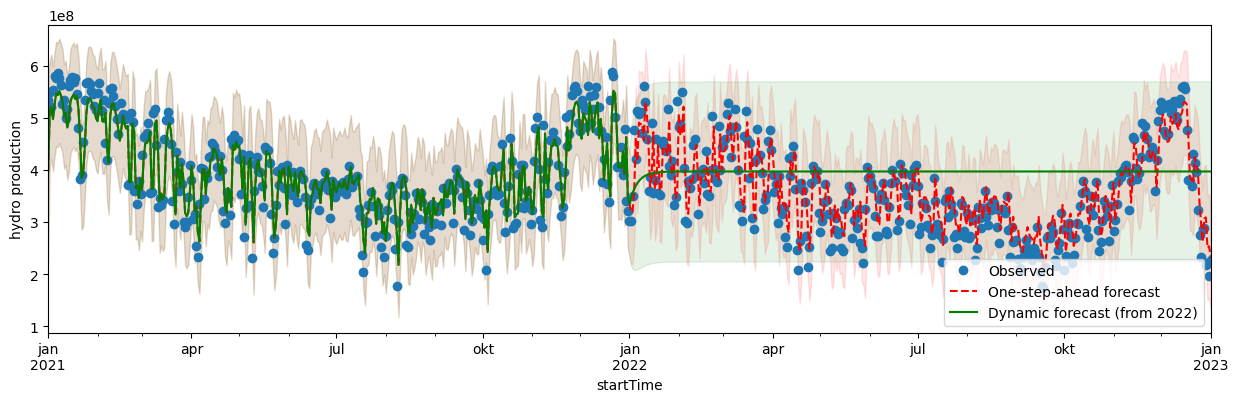

In [54]:
import matplotlib.pyplot as plt 
# Compare the one-step-ahead predictions to the dynamic predictions
fig, ax = plt.subplots(figsize=(15,4))
npre = 4
ax.set(title='', xlabel='Date', ylabel='hydro production')

# Plot data points
df_sarimax[df_sarimax['productionGroup']=='hydro'].loc['2021-01-01':'2023-01-01', 'quantityKwh'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2021-01-01':'2023-01-01'].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2021-01-01':'2023-01-01']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2021-01-01':'2023-01-01'].plot(ax=ax, style='g', label='Dynamic forecast (from 2022)')
ci = predict_dy_ci.loc['2021-01-01':'2023-01-01']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

#### Notes to self

- fix colourbar in choropleth
- SWC
    - **fix lag**
    - implement dates on x-axis
    - **report correlation after/during extreme weather events**
    - consider implementing energy group selection if time
- SARIMAX
- **bonus content**
- getting control over which years are used where 